# Aufgabe 2 - Benchmarks mit dem Gauß Sampling 
In dieser Datei werden die verschiedenen Gauss-Sampling Strategien mithilfe von verschiedenen Benchmarkumgebungen ausgewertet. Es werden hierbei die benötigten Kollisionstests für die Umgebung ausgewertet und die Rechendauer.

Am Ende wird Bridge mit Gauss verglichen.


### Einbinden aller erforderlichen Bibliotheken und Files 

In [10]:
import matplotlib.pyplot as plt 
%matplotlib inline

import networkx as nx  # Library for hanling graphs (please check 4_Introduction_Graph)
import random # possibility to create random numbers (The "P" in PRM)
import numpy as np
import math


from IPPerfMonitor import IPPerfMonitor
# sort nearest neighbour brute force
import heapq
import copy

# reduce coding effort by using function provided by scipy
from scipy.spatial.distance import euclidean


#imports for Benchmarks
import importlib # usfull to relaod Files without the need to restart the kernel 
import IPTestSuite # import the enviroment for our Benchmarks 
dim=2

importlib.reload(IPTestSuite)

<module 'IPTestSuite' from 'c:\\Users\\jonas\\Documents\\08_Master\\Python_Projekte\\Roboter_Programmierung\\Roboterprogrammierung_Projektarbeit\\IPTestSuite.py'>

### "inSameConntectedCoponent" 
Die Funktion schaut ob die übergebenen Punkte in der selben Komponente liegen

In [11]:
def inSameConnectedComponent(node1, node2, graph):
    """ Check whether to nodes are part of the same connected component using
        functionality from NetworkX
    """
    for connectedComponent in nx.connected_components(graph):
        if (node1 in connectedComponent) & (node2 in connectedComponent):
            return True
        
    return False

### "nearestNeighboursX" 
 Die Funktion  findet zu einem gegebenen Punkt alle Punkte in einem gegebenen Radius und sortiert diese mit aufsteigender Distanz in einen Heap 

In [12]:

def nearestNeighboursX(pos, graph, radius):
    """ Brute Force method to find all nodes of a 
    graph near the given position **pos** with in the distance of
    **radius** in **increasing order**"""
    
    heap = list()
    for node in graph.nodes(data=True): # using (data=True) will generate a list of nodes with all attributes
        if euclidean(node[1]['pos'],pos) < radius:
            # use a heap-queue to sort the nodes in increasing order
            heapq.heappush(heap, (euclidean(node[1]['pos'] ,pos), node))
            #if len(heap) > 2 :
            #    break

    result = list()
    while len(heap) > 0 :
         result.append(heapq.heappop(heap)) 
    
    return result
            
            

### "Orignal": Normal Gauß Sampling 

Die Grundidee des Gauß Sampling wie in "Aufgabe1_explanation_gaussian.ipynb" beschrieben

In [13]:
def normal_Gaus_Sampling(collChecker):
    
    # Get the limites for the graph 
    limits = collChecker.getEnvironmentLimits()   
    # Get a random position within the limits    
    pos = [random.uniform(limit[0],limit[1]) for limit in limits]
    # get a distance for the second Point over a gaussian distribution 
    d=np.random.normal(1,0.5) # get a distance d for the second point over a normal gaussian distribution
    pos_x=pos[0]# store the x value
    pos_y=pos[1]# store the y value
    
    # get a random angle between 0 and 360
    alpha=random.uniform(0,360)*(math.pi/180)
    # calculate the new Point with the random angle and the selected distance d 
    pos2_x=d*math.cos(alpha)+pos_x # calculate the x value of pos2
    pos2_y=d*math.sin(alpha)+pos_y# calculate the y valur of pos2 
    # store the Point 
    pos2=[pos2_x,pos2_y]# store pos2


        
    # check if the first Point is in collision and the secon ist collision free 
    if not collChecker.pointInCollision(pos2) and collChecker.pointInCollision(pos):
        return pos2 # return pos2 wich now can be added to the roadmap  
    # check if the second Point is in collision and the first is collision free 
    if not collChecker.pointInCollision(pos) and collChecker.pointInCollision(pos2):
        return pos # return pos wich now can be added to the roadmap  
    #if none of the both above conditions is true return False 
    return False

### "learn_RoadmapNearestNeighbour" 
Die Funktion erzeugt eine vorgegebene Anzahl an Punkte mit dem Bridge Sampling Verfahren und fügte diese der Roadmap hinzu

In [14]:
def learnRoadmapNearestNeighbour(graph, dim, radius, numNodes, collisionChecker):
    i = 1
    while i < numNodes: # generate new nodes until the desired number has been reached 
      
        pos=False# initalize the pos var 
        #num_loops = 0 # set the counter for the count of the loops  to zero 
        while pos==False: # create a new point with the Bridge Sampling until a valid point is returned 
            #num_loops += 1# increase the loop counter 
            pos = normal_Gaus_Sampling(collisionChecker)
           #if num_loops > 200:# if the loop counter is over 200 stop the sampling - protect from deadlocks 
                #break
        
        # Find set of candidates to connect to sorted by distance
        #result = nearestNeighboursX(pos, graph, radius) # commented out because we dont want the result path for our Benchmarks 
        
        # check connection
        if pos is not False:
            graph.add_node(i, pos=pos)
            
        # commented out because we dont want the result path edges for our Benchmarks 
        """
        for idx, data in enumerate(result):
            if not inSameConnectedComponent(i,data[1][0],graph):
                if not collisionChecker.lineInCollision(pos,data[1][1]['pos']):
                    graph.add_edge(i,data[1][0])
        """           
        i+=1

###  "find_Path" 
 Die Funktion versucht einen Pfad von der Start zur Ziepose zu finden mit der erzeugten Roadmap 

In [15]:
def findPath(graph, start, goal,collisionChecker):
    # find nearest, collision-free connection between node on graph and start
    result = nearestNeighboursX(start, graph, radius)
    for node in result:
        if not collisionChecker.lineInCollision(start,node[1][1]['pos']):
            graph.add_node("start", pos=start)
            graph.add_edge("start",node[1][0])
            break;
    # find nearest, collision-free connection between node on graph and goal
    result = nearestNeighboursX(goal, graph, radius)
    
    for node in result:
        if not collisionChecker.lineInCollision(goal,node[1][1]['pos']):
            graph.add_node("goal", pos=goal)
            graph.add_edge("goal",node[1][0])
            break;
    # find shortest path on graph
    path = nx.shortest_path(graph,"start","goal")
    # return nodelist
    return path

###  "basicPRMVisualize" 
Die Funktion visualisiert die Benchmark umgebungen mit deren Hindernissen und der dazu erzeugten Roadmap


In [16]:
def basicPRMVisualize(graph, collChecker, solution, nodeSize=300.0, ax=None):
    # get a list of posiations of all nodes by returning the content of the attribute 'pos'
    pos = nx.get_node_attributes(graph,'pos')
    
    # draw graph (nodes colorized by degree)
    nx.draw_networkx_nodes(graph, pos,  cmap=plt.cm.Blues, ax = ax, node_size=nodeSize)
    
     # commented out because we only want the nodes and not the edges for our Benchmark 
    """
    nx.draw_networkx_edges(graph,pos,
                                ax = ax
                                )
    """
   
    collChecker.drawObstacles(ax)
    
    
    # draw nodes based on solution path
    Gsp = nx.subgraph(graph,solution)
    nx.draw_networkx_nodes(Gsp,pos,
                            node_size=300,
                             node_color='g',  ax = ax)
        
    # draw edges based on solution path
    # commented out because we dont want them in our Benchmark 
    #nx.draw_networkx_edges(Gsp,pos,alpha=0.8,edge_color='g',width=10,  ax = ax)
        
    # draw start and goal
    # commented out because we dont want them in our Benchmark 
    """"
    if "start" in graph.nodes(): 
        nx.draw_networkx_nodes(graph,pos,nodelist=["start"],
                                   node_size=300,
                                   node_color='#00dd00',  ax = ax)
    if "goal" in graph.nodes():
        nx.draw_networkx_nodes(graph,pos,nodelist=["goal"],
                                   node_size=300,
                                   node_color='#DD0000', ax = ax)
    """
    

### Importieren der Benchmark Umgebung 

In [17]:


for benchmark in IPTestSuite.benchList:
    print(benchmark.name)

Trap
Bottleneck
Fat bottleneck
Spirals
Entrance
Entrances
KIT
Inside
SSL
Ring
Hemispheres
Hammerhead
Zigzag
Spiral
medium
medium2
L-square
Teeth
Gearshift
Squares_easy
Zigzag_medium
Zigzag_hard
Japan
Haystack
HairPerson
M Sahpe(JM)
Random Field (LB)
stick figure (AA)
Double Circle(JM)
Sun Scribble (FP)
Wpoint (SS)
Points Field (NC)
Hi (TN)
S Field
HKA (SS)
HKA (HKA)
tLines (TK)
U Lines (KA)
Ricos Moderne Kunst
Pillars (MA)
Random Bubbles (MS)
Point Matrix (CH)
VFB (LD)
Face (JS)
Maze (AZ)
Robo (FP)
Stickman (MK)
House (AZ)
2030+ (2030+)
Random Bubbles (MS)


### Erzeugen der Roadmap für alle geladenen Benchmarks

Planning:  Trap
Limits [[0.0, 22.0], [0.0, 22.0]]
pointInCollision- Aufrufe 4356
Failed Either source start or target goal is not in G
Planning:  Bottleneck
Limits [[0.0, 22.0], [0.0, 22.0]]


c:\Users\jonas\Documents\08_Master\Python_Projekte\Roboter_Programmierung\Roboterprogrammierung_Projektarbeit\venv\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


pointInCollision- Aufrufe 3848
Failed Either source start or target goal is not in G
Planning:  Fat bottleneck
Limits [[0.0, 22.0], [0.0, 22.0]]
pointInCollision- Aufrufe 4819
Failed Either source start or target goal is not in G
Planning:  Spirals
Limits [[0.0, 22.0], [0.0, 22.0]]
pointInCollision- Aufrufe 2951
Failed Either source start or target goal is not in G
Planning:  Entrance
Limits [[0.0, 22.0], [0.0, 22.0]]
pointInCollision- Aufrufe 1907
Failed No path between start and goal.
Planning:  Entrances
Limits [[0.0, 22.0], [0.0, 22.0]]
pointInCollision- Aufrufe 1594
Failed Either source start or target goal is not in G
Planning:  KIT
Limits [[0.0, 22.0], [0.0, 22.0]]
pointInCollision- Aufrufe 2543
Failed Either source start or target goal is not in G
Planning:  Inside
Limits [[0.0, 22.0], [0.0, 22.0]]
pointInCollision- Aufrufe 1790
Failed No path between start and goal.
Planning:  SSL
Limits [[0.0, 22.0], [0.0, 22.0]]
pointInCollision- Aufrufe 2265


c:\Users\jonas\Documents\08_Master\Python_Projekte\Roboter_Programmierung\Roboterprogrammierung_Projektarbeit\venv\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


Failed Either source start or target goal is not in G
Planning:  Ring
Limits [[0.0, 22.0], [0.0, 22.0]]
pointInCollision- Aufrufe 4962
Failed No path between start and goal.


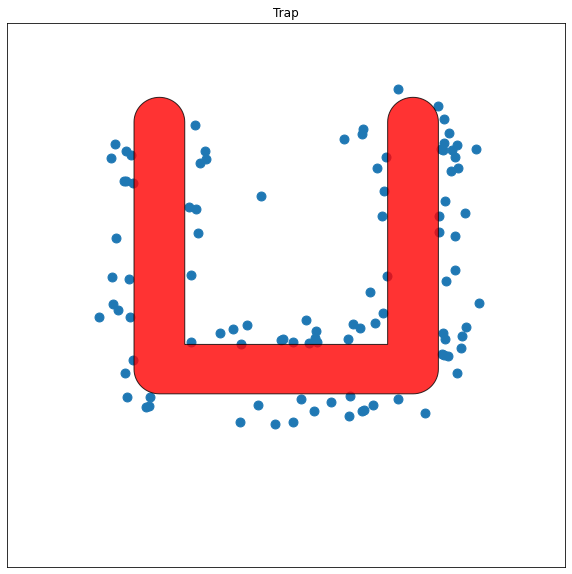

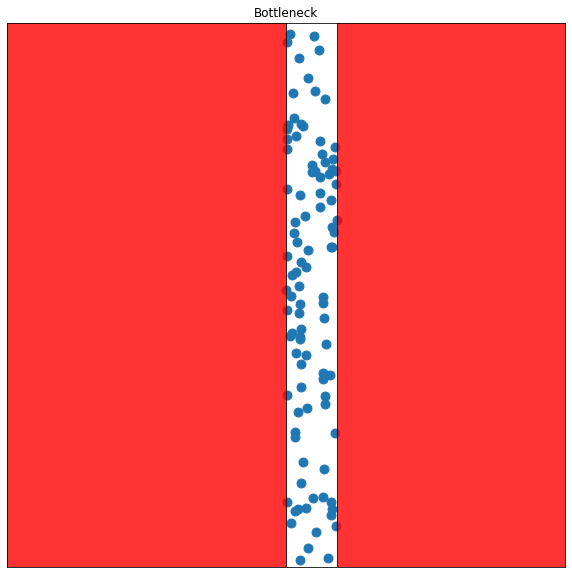

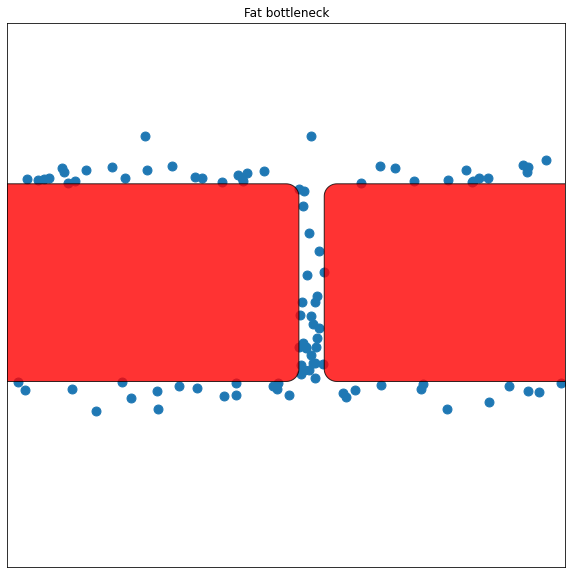

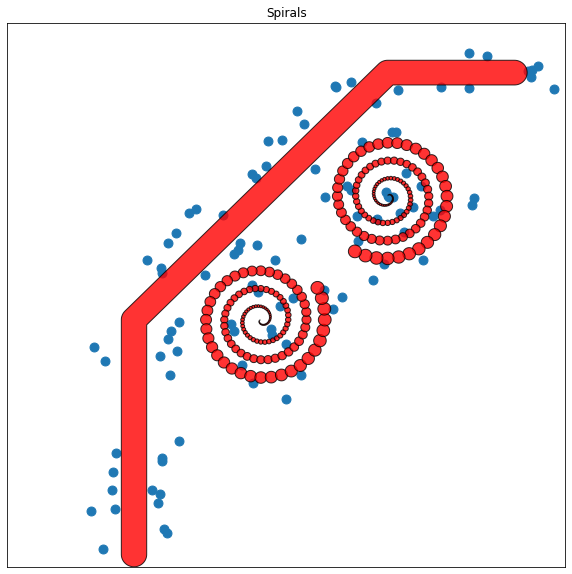

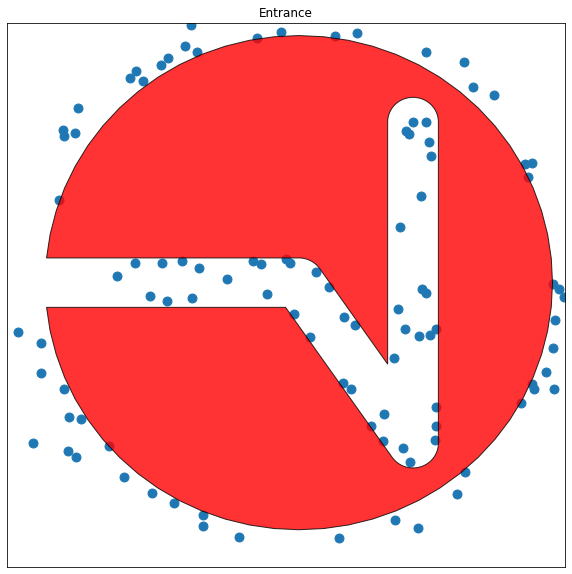

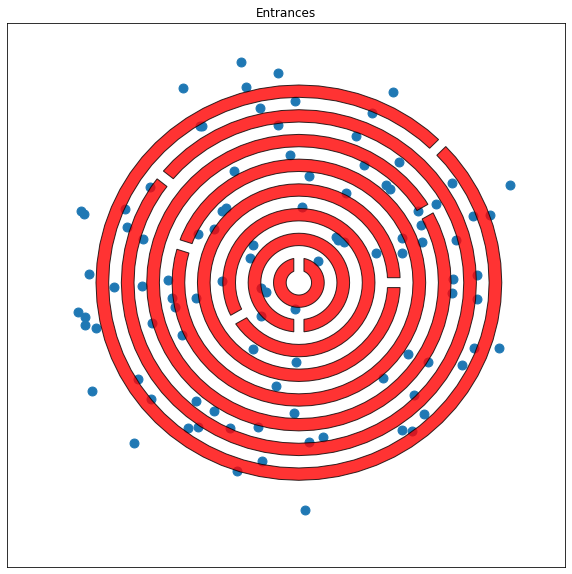

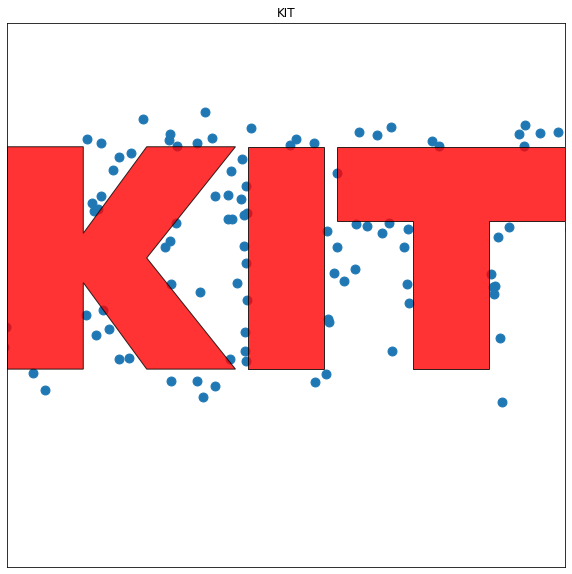

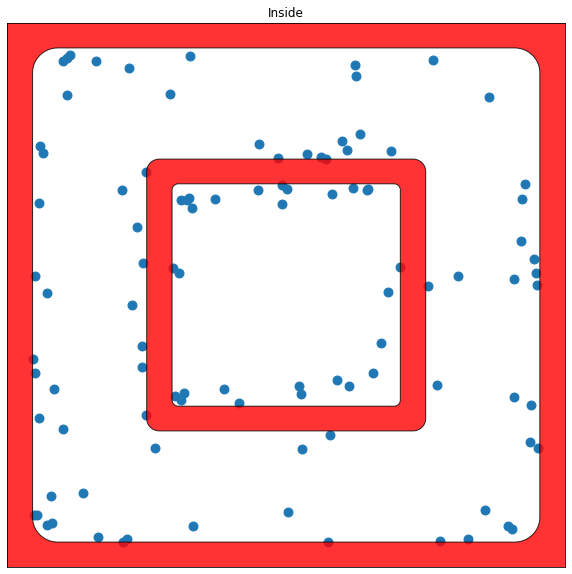

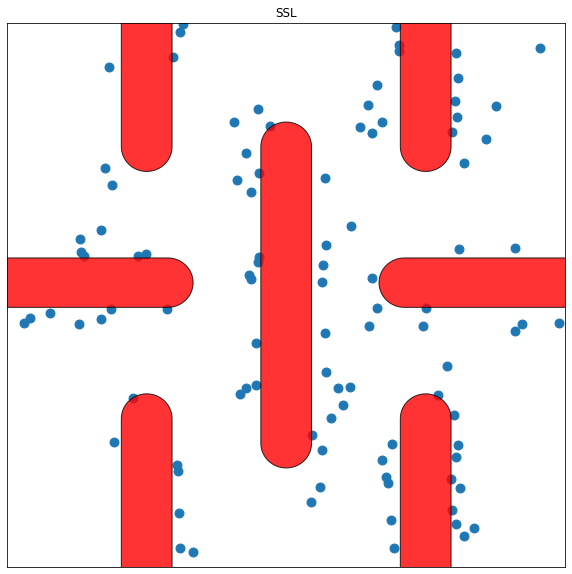

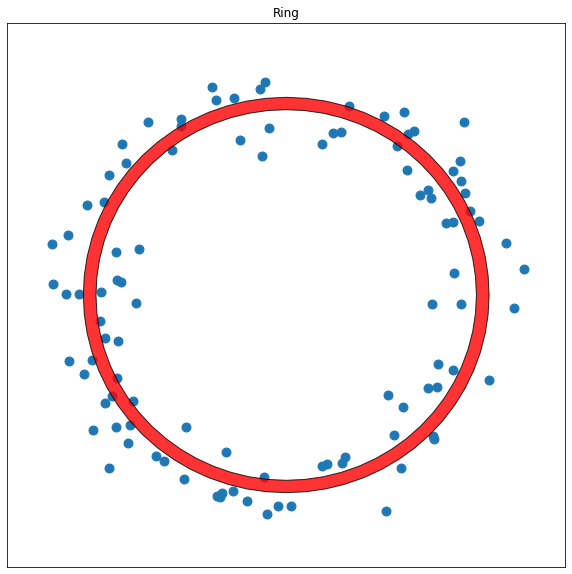

In [18]:
temp_list=IPTestSuite.benchList[:10]

coll_list = []
#iterate through all benchmark environments
for benchmark in temp_list:
    if benchmark.name == "Japan":
        continue
    try:
        print ("Planning: ", benchmark.name)
        print("Limits", benchmark.collisionChecker.getEnvironmentLimits())
        collChecker = benchmark.collisionChecker
        G = nx.Graph()
        #Parameter for the Roadmap
        radius = 3.0
        numNodes = 100

        #Count Collision Checks
        IPPerfMonitor.clearData()        
        learnRoadmapNearestNeighbour(G, dim, radius, numNodes, collChecker)

        Function_infos = IPPerfMonitor.dataFrame()
        counts_for_collision = len(Function_infos[Function_infos["name"]=="pointInCollision"])
        print("pointInCollision- Aufrufe", counts_for_collision)
        #collects the collision checks from the different benchmark enviroments in a list
        coll_list.append(counts_for_collision)
        
        solution = findPath(G,benchmark.startList[0],benchmark.goalList[0], collChecker)
        print(solution, len(solution))
        print(len(G.nodes()))
        
    except Exception as e:
        solution = []
        print ("Failed", e)
    # draw the Roadmap of the benchmark enviroments
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    limits=collChecker.getEnvironmentLimits()
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_title(benchmark.name)
    basicPRMVisualize(G,collChecker,solution,nodeSize=80,ax=ax)

### Ergebnisse der Benchmarks
**Paramter für die Benchmarks:**
* Mittelwert der Gauß Normalverteilung - 0,5
* Standardabweichung der Gauß Normalverteilung - 0,5
* Anzahl der zu erzeugenden Punkte - 100 
* Das Abbruch Krieterium um bei einem zu häfigen Aufruf der Sampling Strategie abzubrechen wurde auskomentiert

<img src="img-ip-5-0/Aufgabe_2_Projektarbeit_Bild_4.png" width=250em style="float: mid;" />
<img src="img-ip-5-0/Aufgabe_2_Projektarbeit_Bild_5.png" width=250em style="float: mid;" />
<img src="img-ip-5-0/Aufgabe_2_Projektarbeit_Bild_6.png" width=250em style="float: mid;" />

Wie auf den Bildern der Benchmarks schön zu sehen ist, werden die Punkte um die Hindernisse herum gelegt. Bei Umgegungen bei denen das Volumen des Hinderniss im Vergleich zum Volumen der Umgebung nur sehr gering ist kann das zu Problemen führen, da dann alle Punkte auf einen kleinen Bereich konzentriert werden. Den Abstand der Punkte zu den Hindernissen kann über die Paramter der Gaußschen Normalverteilung beeinflusst werden.

**Vergleich zwischen Bridge Sampling und Gauß Sampling**

Die Anzahl von 100 Punkten wurde vorgegeben und die Anzahl der Kollisionschecks und die Dauer der Berechungn der einzelnen Punkte verglichen.

<img src="img-ip-5-0/Aufgabe_2_Projektarbeit_Bild_7.png" width=500em style="float: mid;" />

Deutlich zu erkenn ist, dass das Gaußsampling deutlich schneller als das Bridge Sampling ist und weniger Kollisionscheks benötigt. Das liegt vor allem daran, dass beim Bridge Sampling Verfahren ein Punkt mehr auf Kollision geprüft werden muss als beim Gauß Sampling. Des Weiteren ist die Wahrscheinlichkeit, dass 3 Punkte die Bedingungen(Kollision,Kollision,Kollisionsfrei) hintereinander füllen deutlich geringer als beim Gauß Sampling bei denen es nur zwei Bedingungen sind(Kollision,Kollisionsfrei). 
Dennoch lassen sich die beiden Verfahren nur bedingt vergleichen, da sie zwei unterschiedliche Ziele verfolgen. Das Gauß Sampling möchte möglichst viele Punkte um Objekte herum erzeugen. Das Bridge Sampling soll Punkte in engen Passagen erzeugen. Deshalb muss man je nach Umgebung abschätzen welches Verfahren das geeignete ist.